# 第8章: ニューラルネット

第6章で取り組んだニュース記事のカテゴリ分類を題材として，ニューラルネットワークでカテゴリ分類モデルを実装する．なお，この章ではPyTorch, TensorFlow, Chainerなどの機械学習プラットフォームを活用せよ．

## 70. 単語ベクトルの和による特徴量

問題50で構築した学習データ，検証データ，評価データを行列・ベクトルに変換したい．

例えば，学習データについて，すべての事例$x_i$の特徴ベクトル$x_i$を並べた行列$X$と，正解ラベルを並べた行列（ベクトル）$Y$を作成したい．

$$ 
X = \begin{pmatrix} 
  \boldsymbol{x}_1 \\ 
  \boldsymbol{x}_2 \\ 
  \dots \\ 
  \boldsymbol{x}_n \\ 
\end{pmatrix} \in \mathbb{R}^{n \times d},
Y = \begin{pmatrix} 
  y_1 \\ 
  y_2 \\ 
  \dots \\ 
  y_n \\ 
\end{pmatrix} \in \mathbb{N}^{n}
$$

ここで，$n$は学習データの事例数であり，$\boldsymbol{x}_i \in \mathbb{R}^d$ と $y_i \in \mathbb{N}$ はそれぞれ，$i \in \{1, \dots, n\}$ 番目の事例の特徴量ベクトルと正解ラベルを表す． 

なお，今回は「ビジネス」「科学技術」「エンターテイメント」「健康」の4カテゴリ分類である．

$\mathbb{N}_{<4}$ で $4$ 未満の自然数（$0$ を含む）を表すことにすれば，任意の事例の正解ラベル $y_i$ は $y_i \in \mathbb{N}_{<4}$ で表現できる． 

以降では，ラベルの種類数を $L$ で表す（今回の分類タスクでは $L=4$ である）．

$i$ 番目の事例の特徴ベクトル $x_i$ は，次式で求める．

$$
 \boldsymbol{x}_i = \frac{1}{T_i} \sum_{t=1}^{T_i} \mathrm{emb}(w_{i,t})
$$ 

ここで，$i$ 番目の事例は $T_i$ 個の（記事見出しの）単語列 $ (w_{i,1}, w_{i,2}, \dots, w_{i,T_i}) $ から構成され，$ \mathrm{emb}(w) \in \mathbb{R}^d$ は単語 $w$ に対応する単語ベクトル（次元数は $d$ ）である．

すなわち，$i$ 番目の事例の記事見出しを，その見出しに含まれる単語のベクトルの平均で表現したものが $x_i$ である．

今回は単語ベクトルとして，問題60でダウンロードしたものを用いればよい．$300$ 次元の単語ベクトルを用いたので，$d=300$ である．

$i$ 番目の事例のラベル $y_i$ は，次のように定義する．

$$
y_i = \begin{cases}
0 & (\mbox{記事}x_i\mbox{が「ビジネス」カテゴリの場合}) \\
1 & (\mbox{記事}x_i\mbox{が「科学技術」カテゴリの場合}) \\
2 & (\mbox{記事}x_i\mbox{が「エンターテイメント」カテゴリの場合}) \\
3 & (\mbox{記事}x_i\mbox{が「健康」カテゴリの場合}) \\
\end{cases}
$$
 
なお，カテゴリ名とラベルの番号が一対一で対応付いていれば，上式の通りの対応付けでなくてもよい．

以上の仕様に基づき，以下の行列・ベクトルを作成し，ファイルに保存せよ．

学習データの特徴量行列: $ X_{\rm train} \in \mathbb{R}^{N_t \times d} $

学習データのラベルベクトル: $ Y_{\rm train} \in \mathbb{N}^{N_t} $

検証データの特徴量行列: $ X_{\rm valid} \in \mathbb{R}^{N_v \times d} $

検証データのラベルベクトル: $ Y_{\rm valid} \in \mathbb{N}^{N_v} $

評価データの特徴量行列: $ X_{\rm test} \in \mathbb{R}^{N_e \times d} $

評価データのラベルベクトル: $ Y_{\rm test} \in \mathbb{N}^{N_e} $

なお，$N_t$, $N_v$, $N_e$ はそれぞれ，学習データの事例数，検証データの事例数，評価データの事例数である．

In [1]:
import pandas as pd
import gensim
import numpy as np

問題50で構築した学習データ，検証データ，評価データをロード

In [2]:
train = pd.read_csv('../chapter06/train.txt',sep='\t')#,header=None)
valid = pd.read_csv('../chapter06/valid.txt',sep='\t')
test = pd.read_csv('../chapter06/test.txt',sep='\t')

In [3]:
test

,Unnamed: 0,TITLE,CATEGORY
0,223786,"US Stocks Advance as Small-Cap, Internet Share...",b
1,242050,Investors Couldn't Care Less About Data Breaches,t
2,1154,Elephants really are intelligent: Creatures ca...,t
3,197029,National Australia Bank 1st-half profit up 8.5...,b
4,159549,Green Bonds Could Cut Indian Clean-Energy Cost...,b
...,...,...,...
1331,414762,'They took center stage!' Sofia Vergara stuns ...,e
1332,104245,Selena Gomez Fires Her Parents: Heres Five Sta...,e
1333,314941,US housing finance regulator should consider s...,b
1334,344391,BNP Seeks Approval to Continue US Pension Busi...,b


タイトルを単語に分割したものと、正解ラベルを生成

In [4]:
categories = ['b', 't', 'e', 'm']

In [5]:
import re
import spacy

In [6]:
#nlp = spacy.load('en')
nlp = spacy.load("en_core_web_sm")

In [7]:
def tokenize(x):
    x = re.sub(r'\s+', ' ', x)
    x = nlp.make_doc(x)
    x = [d.text for d in x]
    return x

下だめ

In [5]:
def tokenize(x):
    x = x.replace('.','') #ピリオド消す
    x = x.replace(',','') #カンマ消す
    x = x.replace(':','')
    x = x.replace('?','')
    x = x.replace('!','')
    x = x.replace('"','')
    x = x.replace('-','')
    
    words = x.split(' ') #空白文字で区切る
    return words

In [8]:
def read_dataset(dataset_name):
    #dataset = [line.split('\t') for line in dataset_name] # [インデックス、タイトル、ラベル]
    
    # 単語に分割
    dataset_x = dataset_name.iloc[:, 1]
    dataset_x = [tokenize(line) for line in dataset_x]
    #dataset_x = [tokenize(line[1]) for line in dataset_name]
    # 正解ラベル
    dataset_t = dataset_name.iloc[:, 2]
    dataset_t = [categories.index(line) for line in dataset_t]
    
    return dataset_x, dataset_t

In [9]:
train_x, train_t = read_dataset(train)
valid_x, valid_t = read_dataset(valid)
test_x, test_t = read_dataset(test)

In [10]:
train_x[:5]

[['Bulgaria',
  "'s",
  'third',
  'biggest',
  'lender',
  'says',
  'no',
  'restrictions',
  'on',
  'operations'],
 ['Party',
  'tents',
  'go',
  'up',
  'on',
  'the',
  'eve',
  'of',
  'Jessica',
  'Simpson',
  "'s",
  'wedding'],
 ['UK',
  'shares',
  'slide',
  'on',
  'China',
  'growth',
  'concerns',
  ',',
  'geopolitical',
  'tension'],
 ['Scott',
  'Derrickson',
  'To',
  'Direct',
  '"',
  'Dr.',
  'Strange',
  '"',
  '-',
  'Are',
  'We',
  'In',
  'For',
  'A',
  'Darker',
  'Marvel',
  'Flick',
  '?'],
 ['Obama',
  'dedicates',
  'National',
  'September',
  '11',
  'Memorial',
  'Museum',
  'as',
  "'",
  'a',
  'sacred',
  'place',
  '...']]

In [11]:
print(train_t[:5])
print(train_t.shape)

[0, 2, 0, 2, 2]


AttributeError: 'list' object has no attribute 'shape'

単語ベクトルとして，問題60でダウンロードしたものを用いる。

In [12]:
model = gensim.models.KeyedVectors.load_word2vec_format('../chapter07/data/GoogleNews-vectors-negative300.bin', binary=True)

train_x, valid_x, test_x を特徴ベクトル mtrain_v, valid_v, test_v に変換

In [13]:
import torch

In [14]:
def sent_to_vector(words):
    lst = [torch.tensor(model[w]) for w in words if w in model]
    
    if len(lst)==0:
        print(words)

    return sum(lst) / len(lst)

def dataset_to_vector(dataset):
    return torch.stack([sent_to_vector(words) for words in dataset]) # words : タイトルの単語リスト

下だめ

In [18]:
def dataset_to_vector(dataset):
    x, y = [], []
    
    for data in dataset:
                    
        x = (np.array([model[w] for w in data if w in model]))
        
        if np.sum(x) == 0:
            x = np.zeros((1, 300))
            
        # fx.write(" ".join([str(i) for i in list(x.mean(axis=0))]) + "\n"
        # fy.write(str(category[tmp[0]]) + "\n")
        
        return x

In [15]:
train_v = dataset_to_vector(train_x)
valid_v = dataset_to_vector(valid_x)
test_v = dataset_to_vector(test_x)

In [16]:
print(train_v.shape)
print(train_v[0])

torch.Size([10684, 300])
tensor([ 7.3785e-02, -6.3388e-02,  7.5711e-02,  4.1701e-02,  2.1023e-04,
        -1.1049e-01,  5.1175e-02, -4.1450e-02,  1.5218e-01,  5.2985e-02,
        -3.3230e-03, -7.1730e-02,  1.9511e-02,  7.0584e-02, -1.0632e-01,
        -9.3257e-03,  5.1765e-02, -4.6007e-02, -1.5815e-02, -1.8214e-02,
         1.9033e-02,  2.8911e-03, -3.3285e-02,  6.2113e-02,  1.5086e-02,
        -3.9117e-02, -6.0303e-02,  4.0744e-02, -2.6367e-02,  9.0617e-02,
         9.6300e-04, -4.4723e-02,  5.0602e-02,  4.9127e-02, -2.0616e-02,
        -2.5906e-03, -3.5225e-02,  4.8898e-02,  1.2040e-01,  4.8564e-02,
         3.8089e-02, -1.5744e-01,  7.8444e-02,  1.9314e-02, -2.8364e-02,
        -2.0501e-02,  2.2169e-02,  1.6832e-02, -6.2500e-02,  1.5215e-02,
         3.1359e-02,  2.5762e-02,  9.4944e-05,  4.5878e-02, -4.1714e-02,
        -4.9344e-02, -1.3718e-01,  5.4742e-02,  6.2120e-03, -1.3562e-01,
        -7.0801e-02,  4.9045e-02, -7.1669e-02, -6.7383e-02, -5.5135e-02,
        -1.7359e-02,  1.16

pickleで保存

In [17]:
import pickle

In [18]:
train_t = torch.tensor(train_t).long()
valid_t = torch.tensor(valid_t).long()
test_t = torch.tensor(test_t).long()

In [19]:
train_t

tensor([0, 2, 0,  ..., 0, 2, 2])

In [25]:
with open('data/train.feature.pickle', 'wb') as f:
    pickle.dump(train_v, f)
with open('data/train.label.pickle', 'wb') as f:
    pickle.dump(train_t, f)

with open('data/valid.feature.pickle', 'wb') as f:
    pickle.dump(valid_v, f)
with open('data/valid.label.pickle', 'wb') as f:
    pickle.dump(valid_t, f)

with open('data/test.feature.pickle', 'wb') as f:
    pickle.dump(test_v, f)
with open('data/test.label.pickle', 'wb') as f:
    pickle.dump(test_t, f)

## 71. 単層ニューラルネットワークによる予測

問題70で保存した行列を読み込み，学習データについて以下の計算を実行せよ．

$$
\hat{\boldsymbol{y}}_1 = {\rm softmax}(\boldsymbol{x}_1 W), \\
\hat{Y} = {\rm softmax}(X_{[1:4]} W)
$$

ただし，$softmax$ はソフトマックス関数，$ X_{[1:4]} \in \mathbb{R}^{4 \times d} $ は特徴ベクトル$x_1$, $x_2$, $x_3$, $x_4$ を縦に並べた行列である．

$$
X_{[1:4]} = \begin{pmatrix} 
  \boldsymbol{x}_1 \\ 
  \boldsymbol{x}_2 \\ 
  \boldsymbol{x}_3 \\ 
  \boldsymbol{x}_4 \\ 
\end{pmatrix}
$$

行列 $ W \in \mathbb{R}^{d \times L} $ は単層ニューラルネットワークの重み行列で，ここではランダムな値で初期化すればよい（問題73以降で学習して求める）．

なお，$ \hat{\boldsymbol{y}}_1 \in \mathbb{R}^L $ は未学習の行列 $W$ で事例 $x_1$ を分類したときに，各カテゴリに属する確率を表すベクトルである． 

同様に，$ \hat{Y} \in \mathbb{R}^{n \times L} $ は，学習データの事例 $x_1$,$x_2$,$x_3$,$x_4$ について，各カテゴリに属する確率を行列として表現している．

In [20]:
# 特徴ベクトル
train_v.shape

torch.Size([10684, 300])

In [21]:
train_t.shape

torch.Size([10684])

In [22]:
class Perceptron(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.fc = torch.nn.Linear(input_size, output_size, bias = False)
        torch.nn.init.xavier_normal_(self.fc.weight) # 単層ニューラルネットワークの重み行列はランダムな値で初期化

    def forward(self, x):
        x = self.fc(x)
        return x

In [23]:
model = Perceptron(300, 4)

In [24]:
train_v

tensor([[ 0.0738, -0.0634,  0.0757,  ..., -0.0151,  0.0485, -0.0923],
        [ 0.0486, -0.0027, -0.0415,  ..., -0.0585,  0.0446,  0.0276],
        [ 0.0182,  0.0247, -0.0247,  ..., -0.0096,  0.1365, -0.0576],
        ...,
        [-0.0355,  0.0380,  0.0113,  ..., -0.0848,  0.0651, -0.0568],
        [-0.0112,  0.0212, -0.0893,  ...,  0.0403,  0.0788,  0.0139],
        [ 0.1577,  0.0992, -0.1321,  ..., -0.0760, -0.0445, -0.0994]])

In [25]:
train_v.shape

torch.Size([10684, 300])

$$
\hat{\boldsymbol{y}}_1 = {\rm softmax}(\boldsymbol{x}_1 W) \
$$

In [26]:
y = model(train_v[0])
y = torch.softmax(y, dim=-1)
y

tensor([0.2478, 0.2629, 0.2435, 0.2459], grad_fn=<SoftmaxBackward0>)

$$
\hat{Y} = {\rm softmax}(X_{[1:4]} W) \
$$

In [27]:
Y = model(train_v[:4])
Y = torch.softmax(Y, dim=-1)
Y

tensor([[0.2478, 0.2629, 0.2435, 0.2459],
        [0.2303, 0.2595, 0.2351, 0.2751],
        [0.2374, 0.2516, 0.2744, 0.2366],
        [0.2367, 0.2420, 0.2628, 0.2585]], grad_fn=<SoftmaxBackward0>)

## 72. 損失と勾配の計算

学習データの事例 $x_1$ と事例集合 $x_1$,$x_2$,$x_3$,$x_4$ に対して，クロスエントロピー損失と，行列 $W$ に対する勾配を計算せよ．

なお，ある事例$x_i$に対して損失は次式で計算される．

$$
l_i = - \log [\mbox{事例}x_i\mbox{が}y_i\mbox{に分類される確率}]
$$

ただし，事例集合に対するクロスエントロピー損失は，その集合に含まれる各事例の損失の平均とする．

学習データの事例  $x_1$

In [35]:
criterion = torch.nn.CrossEntropyLoss()

In [36]:
y = model(train_v[:1])
t = train_t[:1]

loss = criterion(y, t)
model.zero_grad()
loss.backward()

print('損失 :', loss.item())
print('勾配')
print(model.fc.weight.grad)

損失 : 1.1641709804534912
勾配
tensor([[-0.0508,  0.0436, -0.0521,  ...,  0.0104, -0.0334,  0.0635],
        [ 0.0176, -0.0152,  0.0181,  ..., -0.0036,  0.0116, -0.0221],
        [ 0.0168, -0.0145,  0.0173,  ..., -0.0034,  0.0111, -0.0210],
        [ 0.0163, -0.0140,  0.0167,  ..., -0.0033,  0.0107, -0.0204]])


In [37]:
model.zero_grad()
model.fc.weight.grad

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

事例集合 $x_1$, $x_2$, $x_3$,  $x_4$

In [38]:
y = model(train_v[:4])
t = train_t[:4]

loss = criterion(y, t)
model.zero_grad()
loss.backward()

print('損失 :', loss.item())
print('勾配')
print(model.fc.weight.grad)

損失 : 1.352078914642334
勾配
tensor([[-0.0109,  0.0113, -0.0103,  ...,  0.0002, -0.0232,  0.0240],
        [ 0.0107,  0.0023,  0.0012,  ..., -0.0058,  0.0203, -0.0107],
        [-0.0099, -0.0160,  0.0083,  ...,  0.0112, -0.0172, -0.0028],
        [ 0.0101,  0.0024,  0.0008,  ..., -0.0055,  0.0201, -0.0105]])


## 73. 確率的勾配降下法による学習

確率的勾配降下法（SGD: Stochastic Gradient Descent）を用いて，行列 $W$ を学習せよ．

なお，学習は適当な基準で終了させればよい（例えば「100エポックで終了」など）．

In [39]:
from torch.utils.data import TensorDataset, DataLoader

In [40]:
class LogisticRegression(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(300, 4),
        )
    def forward(self, X):
        return self.net(X)

In [41]:
train_t.shape

torch.Size([10684])

In [42]:
train_t.shape

torch.Size([10684])

In [44]:
model = LogisticRegression()

ds = TensorDataset(train_v, train_t)


# DataLoaderを作成
loader = DataLoader(ds, batch_size=1, shuffle=True)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.net.parameters(), lr=1e-1)

num_epochs = 10
print("epoch\tloss")
for epoch in range(num_epochs):
    sum_loss = 0
    for x, y in loader:
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        sum_loss += loss
    print(f"{epoch+1}\t{sum_loss:.4f}")

epoch	loss
1	4289.4180
2	3175.0735
3	2950.5535
4	2833.9585
5	2740.6562
6	2688.7427
7	2643.5425
8	2599.5818
9	2579.4985
10	2556.8745


## 74. 正解率の計測

問題73で求めた行列を用いて学習データおよび評価データの事例を分類したとき，その正解率をそれぞれ求めよ．

In [36]:
def accuracy(pred, label):
    pred = np.argmax(pred.data.numpy(), axis=1)
    label = label.data.numpy()
    
    return (pred == label).mean()

In [53]:
pred = model(train_v)
print('学習データでの正解率 :', accuracy(pred, train_t))

学習データでの正解率 : 0.9215649569449644


In [54]:
pred = model(valid_v)
print('評価データでの正解率 :', accuracy(pred, valid_t))

評価データでの正解率 : 0.906437125748503


## 75. 損失と正解率のプロット

問題73のコードを改変し，各エポックのパラメータ更新が完了するたびに，訓練データでの損失，正解率，検証データでの損失，正解率をグラフにプロットし，学習の進捗状況を確認できるようにせよ．

In [30]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()

from torch.utils.data import TensorDataset, DataLoader

In [31]:
class LogisticRegression(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(300, 4),
        )
    def forward(self, X):
        return self.net(X)

In [32]:
model = LogisticRegression()
ds = TensorDataset(train_v, train_t)

# DataLoaderを作成
loader = DataLoader(ds, batch_size=1, shuffle=True)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.net.parameters(), lr=1e-1)

In [44]:
log_train = []
log_valid = []

for epoch in range(10):
    for xx, yy in loader:
        y_pred = model(xx)
        loss = loss_fn(y_pred, yy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    with torch.no_grad():
        y_pred = model(train_v)
        loss_train = loss_fn(y_pred, train_t)
        acc_train = accuracy(y_pred,train_t)
        
        log_train.append([loss_train, acc_train])
        
        # ログを出力
        print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}')
        
        #writer.add_scalar('Loss/train', loss, epoch)
        #writer.add_scalar('Accuracy/train', accuracy(y_pred,train_t), epoch)
        
        y_pred = model(valid_v)
        loss_valid = loss_fn(y_pred, valid_t)
        acc_valid = accuracy(y_pred,valid_t)
        
        log_valid.append([loss_valid, acc_valid])
        
        print(f'epoch: {epoch + 1}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}')
        
        
        #writer.add_scalar('Loss/valid', loss, epoch)
        #writer.add_scalar('Accuracy/valid', accuracy(y_pred,valid_t), epoch)

epoch: 1, loss_train: 0.2246, accuracy_train: 0.9190
epoch: 1, loss_valid: 0.2784, accuracy_valid: 0.8960
epoch: 2, loss_train: 0.2137, accuracy_train: 0.9255
epoch: 2, loss_valid: 0.2577, accuracy_valid: 0.9087
epoch: 3, loss_train: 0.2107, accuracy_train: 0.9265
epoch: 3, loss_valid: 0.2558, accuracy_valid: 0.9072
epoch: 4, loss_train: 0.2195, accuracy_train: 0.9225
epoch: 4, loss_valid: 0.2644, accuracy_valid: 0.9072
epoch: 5, loss_train: 0.2143, accuracy_train: 0.9224
epoch: 5, loss_valid: 0.2522, accuracy_valid: 0.9079
epoch: 6, loss_train: 0.2091, accuracy_train: 0.9277
epoch: 6, loss_valid: 0.2575, accuracy_valid: 0.9109
epoch: 7, loss_train: 0.2094, accuracy_train: 0.9272
epoch: 7, loss_valid: 0.2588, accuracy_valid: 0.9102
epoch: 8, loss_train: 0.2083, accuracy_train: 0.9277
epoch: 8, loss_valid: 0.2590, accuracy_valid: 0.9109
epoch: 9, loss_train: 0.2091, accuracy_train: 0.9255
epoch: 9, loss_valid: 0.2543, accuracy_valid: 0.9087
epoch: 10, loss_train: 0.2089, accuracy_train:

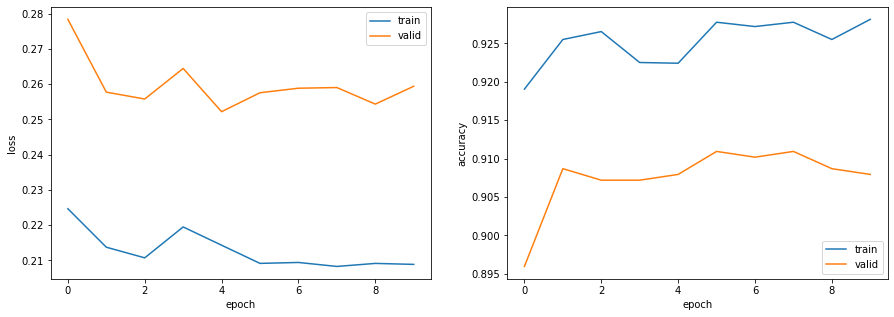

In [45]:
from matplotlib import pyplot as plt

# 視覚化
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(np.array(log_train).T[0], label='train')
ax[0].plot(np.array(log_valid).T[0], label='valid')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[1].plot(np.array(log_train).T[1], label='train')
ax[1].plot(np.array(log_valid).T[1], label='valid')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend()
plt.show()

## 76. チェックポイント

問題75のコードを改変し，各エポックのパラメータ更新が完了するたびに，チェックポイント（学習途中のパラメータ（重み行列など）の値や最適化アルゴリズムの内部状態）をファイルに書き出せ．

In [46]:
class LogisticRegression(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(300, 4),
        )
    def forward(self, X):
        return self.net(X)

In [47]:
model = LogisticRegression()
ds = TensorDataset(train_v, train_t)

# DataLoaderを作成
loader = DataLoader(ds, batch_size=1, shuffle=True)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.net.parameters(), lr=1e-1)

In [50]:
log_train = []
log_valid = []

for epoch in range(10):
    for xx, yy in loader:
        y_pred = model(xx)
        loss = loss_fn(y_pred, yy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    with torch.no_grad():
        y_pred = model(train_v)
        loss_train = loss_fn(y_pred, train_t)
        acc_train = accuracy(y_pred,train_t)
        print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}')
        
        log_train.append([loss_train, acc_train])
        
        #writer.add_scalar('Loss/train', loss, epoch)
        #writer.add_scalar('Accuracy/train', accuracy(y_pred,y_train), epoch)
        
        y_pred = model(valid_v)
        loss = loss_fn(y_pred, valid_t)
        acc = accuracy(y_pred, valid_t)
        print(f'epoch: {epoch + 1}, loss_valid: {loss:.4f}, accuracy_valid: {acc:.4f}')
        
        log_valid.append([loss_valid, acc_valid])
        
        #writer.add_scalar('Loss/valid', loss, epoch)
        #writer.add_scalar('Accuracy/valid', accuracy(y_pred,y_valid), epoch)
        
        
        # チェックポイントの保存
        torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')
        
        # 学習途中のパラメータ、最適化アルゴリズムの内部状態を state_dict() で取得
        #torch.save(model.state_dict(), base+'output/'+str(epoch)+'.model')
        #torch.save(optimizer.state_dict(), base+'output/'+str(epoch)+'.param')

epoch: 1, loss_train: 0.2605, accuracy_train: 0.9146
epoch: 1, loss_valid: 0.2586, accuracy_valid: 0.9064
epoch: 2, loss_train: 0.2608, accuracy_train: 0.9107
epoch: 2, loss_valid: 0.2647, accuracy_valid: 0.9012
epoch: 3, loss_train: 0.2496, accuracy_train: 0.9120
epoch: 3, loss_valid: 0.2486, accuracy_valid: 0.9079
epoch: 4, loss_train: 0.2376, accuracy_train: 0.9192
epoch: 4, loss_valid: 0.2427, accuracy_valid: 0.9087
epoch: 5, loss_train: 0.2338, accuracy_train: 0.9200
epoch: 5, loss_valid: 0.2442, accuracy_valid: 0.9154
epoch: 6, loss_train: 0.2387, accuracy_train: 0.9160
epoch: 6, loss_valid: 0.2441, accuracy_valid: 0.9064
epoch: 7, loss_train: 0.2469, accuracy_train: 0.9126
epoch: 7, loss_valid: 0.2520, accuracy_valid: 0.9042
epoch: 8, loss_train: 0.2263, accuracy_train: 0.9222
epoch: 8, loss_valid: 0.2420, accuracy_valid: 0.9087
epoch: 9, loss_train: 0.2255, accuracy_train: 0.9224
epoch: 9, loss_valid: 0.2435, accuracy_valid: 0.9102
epoch: 10, loss_train: 0.2267, accuracy_train:

## 77. ミニバッチ化

問題76のコードを改変し，$B$ 事例ごとに損失・勾配を計算し，行列 $W$ の値を更新せよ（ミニバッチ化）．

$B$ の値を $ 1, 2, 4, 8, \dots $ と変化させながら，1エポックの学習に要する時間を比較せよ．

In [51]:
import time
from torch.utils.data import TensorDataset, DataLoader

In [52]:
class LogisticRegression(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(300, 4),
        )
    def forward(self, X):
        return self.net(X)

In [53]:
model = LogisticRegression()

ds = TensorDataset(train_v, train_t)

loss_fn = torch.nn.CrossEntropyLoss()

In [54]:
ls_bs = [2**i for i in range(15)]
ls_time = []

for bs in ls_bs:
    loader = DataLoader(ds, batch_size=bs, shuffle=True)
    optimizer = torch.optim.SGD(model.net.parameters(), lr=1e-1)
    
    for epoch in range(1):
        start = time.time()
        
        for xx, yy in loader:
            y_pred = model(xx)
            loss = loss_fn(y_pred, yy)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
    ls_time.append(time.time()-start)
    
print (ls_time)

[2.154160261154175, 1.24592924118042, 0.6872358322143555, 0.37796998023986816, 0.205765962600708, 0.12842297554016113, 0.08576393127441406, 0.06997179985046387, 0.0560908317565918, 0.05320572853088379, 0.0538630485534668, 0.13495516777038574, 0.07517194747924805, 0.06455612182617188, 0.15059304237365723]


バッチサイズが大きいほど計算時間が短くなってる

## 78. GPU上での学習

問題77のコードを改変し，GPU上で学習を実行せよ．

In [55]:
class LogisticRegression(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(300, 4),
        )
    def forward(self, X):
        return self.net(X)

In [56]:
model = LogisticRegression()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

ds = TensorDataset(train_v.to(device), train_t.to(device))
loss_fn = torch.nn.CrossEntropyLoss()

In [57]:
ls_bs = [2**i for i in range(15)]
ls_time = []

for bs in ls_bs:
    loader = DataLoader(ds, batch_size=bs, shuffle=True)
    optimizer = torch.optim.SGD(model.net.parameters(), lr=1e-1)
    
    for epoch in range(1):
        start = time.time()
        
        for xx, yy in loader:
            y_pred = model(xx)
            loss = loss_fn(y_pred, yy)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
    ls_time.append(time.time()-start)

print (ls_time)

[2.181788921356201, 1.4010851383209229, 0.7585909366607666, 0.3948509693145752, 0.2123887538909912, 0.12921810150146484, 0.08802294731140137, 0.0658407211303711, 0.05542707443237305, 0.05268526077270508, 0.055005788803100586, 0.13242077827453613, 0.07445502281188965, 0.13447189331054688, 0.08296513557434082]


## 79. 多層ニューラルネットワーク

問題78のコードを改変し，バイアス項の導入や多層化など，ニューラルネットワークの形状を変更しながら，高性能なカテゴリ分類器を構築せよ．

In [58]:
class MLP(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(300, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 4),
        )
    def forward(self, X):
        return self.net(X)

In [59]:
model = MLP()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

ds = TensorDataset(train_v.to(device), train_t.to(device))
loss_fn = torch.nn.CrossEntropyLoss()

In [60]:
loader = DataLoader(ds, batch_size=1024, shuffle=True)
optimizer = torch.optim.SGD(model.net.parameters(), lr=1e-1)

In [63]:
log_train = []
log_valid = []

for epoch in range(100):
    # 開始時刻の記録
    s_time = time.time()
    
    for xx, yy in loader:
        y_pred = model(xx)
        loss = loss_fn(y_pred, yy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    with torch.no_grad():
        y_pred = model(train_v.to(device))
        loss_train = loss_fn(y_pred, train_t.to(device))
        acc_train = accuracy(y_pred.cpu(), train_t.cpu())
        
        y_pred = model(valid_v.to(device))
        loss_valid = loss_fn(y_pred, valid_t.to(device))
        acc_valid = accuracy(y_pred.cpu(), valid_t.cpu())
        
        log_train.append([loss_train, acc_train])
        log_valid.append([loss_valid, acc_valid])

        # 終了時刻の記録
        e_time = time.time()
    
        # ログを出力
        print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec') 


print (acc_train, acc_valid)

epoch: 1, loss_train: 0.3462, accuracy_train: 0.8871, loss_valid: 0.3249, accuracy_valid: 0.8967, 0.1686sec
epoch: 2, loss_train: 0.3444, accuracy_train: 0.8879, loss_valid: 0.3234, accuracy_valid: 0.8982, 0.0717sec
epoch: 3, loss_train: 0.3426, accuracy_train: 0.8882, loss_valid: 0.3217, accuracy_valid: 0.8990, 0.0646sec
epoch: 4, loss_train: 0.3408, accuracy_train: 0.8885, loss_valid: 0.3202, accuracy_valid: 0.8990, 0.0746sec
epoch: 5, loss_train: 0.3393, accuracy_train: 0.8892, loss_valid: 0.3187, accuracy_valid: 0.8982, 0.0707sec
epoch: 6, loss_train: 0.3376, accuracy_train: 0.8897, loss_valid: 0.3171, accuracy_valid: 0.9004, 0.0643sec
epoch: 7, loss_train: 0.3359, accuracy_train: 0.8926, loss_valid: 0.3157, accuracy_valid: 0.8982, 0.0784sec
epoch: 8, loss_train: 0.3343, accuracy_train: 0.8916, loss_valid: 0.3141, accuracy_valid: 0.9004, 0.1558sec
epoch: 9, loss_train: 0.3329, accuracy_train: 0.8928, loss_valid: 0.3132, accuracy_valid: 0.8975, 0.0682sec
epoch: 10, loss_train: 0.331

epoch: 78, loss_train: 0.2752, accuracy_train: 0.9083, loss_valid: 0.2636, accuracy_valid: 0.9049, 0.1436sec
epoch: 79, loss_train: 0.2748, accuracy_train: 0.9088, loss_valid: 0.2637, accuracy_valid: 0.9079, 0.0650sec
epoch: 80, loss_train: 0.2744, accuracy_train: 0.9076, loss_valid: 0.2622, accuracy_valid: 0.9049, 0.0626sec
epoch: 81, loss_train: 0.2739, accuracy_train: 0.9078, loss_valid: 0.2621, accuracy_valid: 0.9034, 0.0622sec
epoch: 82, loss_train: 0.2734, accuracy_train: 0.9080, loss_valid: 0.2621, accuracy_valid: 0.9042, 0.0654sec
epoch: 83, loss_train: 0.2731, accuracy_train: 0.9093, loss_valid: 0.2620, accuracy_valid: 0.9049, 0.0630sec
epoch: 84, loss_train: 0.2726, accuracy_train: 0.9090, loss_valid: 0.2615, accuracy_valid: 0.9049, 0.0606sec
epoch: 85, loss_train: 0.2722, accuracy_train: 0.9085, loss_valid: 0.2613, accuracy_valid: 0.9049, 0.1387sec
epoch: 86, loss_train: 0.2717, accuracy_train: 0.9082, loss_valid: 0.2609, accuracy_valid: 0.9057, 0.0647sec
epoch: 87, loss_tra

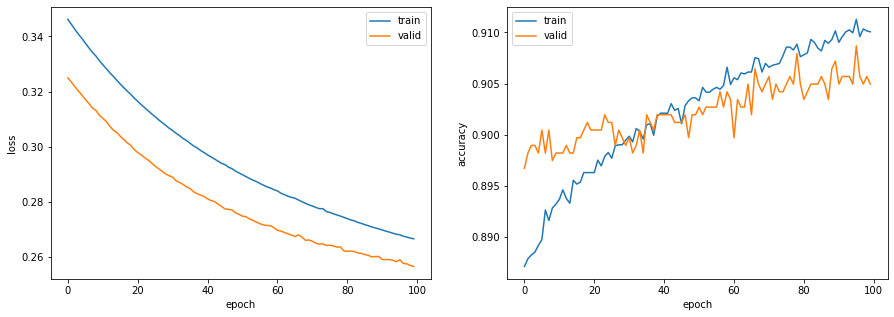

In [65]:
# 視覚化
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(np.array(log_train).T[0], label='train')
ax[0].plot(np.array(log_valid).T[0], label='valid')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[1].plot(np.array(log_train).T[1], label='train')
ax[1].plot(np.array(log_valid).T[1], label='valid')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend()
plt.show()